In [2]:
from boilerplates import *

23/05/04 03:18:39 WARN Utils: Your hostname, zylab resolves to a loopback address: 127.0.1.1; using 10.16.88.247 instead (on interface eno1)
23/05/04 03:18:39 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/04 03:18:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/05/04 03:18:41 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


+-----+-------------------+-------------------+--------+----------------+------------+------------+
|index|            in_time|           out_time|berthage|         section|admin_region|parking_time|
+-----+-------------------+-------------------+--------+----------------+------------+------------+
|    0|2018-09-01 10:10:00|2018-09-01 12:00:00|  201091|荔园路(蛇口西段)|      南山区|        6600|
|    1|2018-09-01 13:43:35|2018-09-01 14:29:35|  201091|荔园路(蛇口西段)|      南山区|        2760|
|    2|2018-09-01 15:10:54|2018-09-01 16:08:54|  201091|荔园路(蛇口西段)|      南山区|        3480|
|    3|2018-09-01 16:34:03|2018-09-01 17:56:03|  201091|荔园路(蛇口西段)|      南山区|        4920|
|    4|2018-09-01 18:40:20|2018-09-01 20:00:20|  201091|荔园路(蛇口西段)|      南山区|        4800|
+-----+-------------------+-------------------+--------+----------------+------------+------------+



/home/yecm/anaconda3/envs/spark/lib/python3.11/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [3]:
df.columns

['index',
 'in_time',
 'out_time',
 'berthage',
 'section',
 'admin_region',
 'parking_time']

In [4]:
# 问题5
# 原本是 停车记录， in, out, b , s
# 首先求 in, out 作为时间戳，覆盖的半小时范围，得到一个列表
# 可以通过
import datetime
def get_lower_bound(time:datetime.datetime):
    return datetime.datetime(time.year, time.month, time.day, time.hour, time.minute//30*30, 0)
def get_time_range(in_time:datetime.datetime, out_time:datetime.datetime):
    in_lower = get_lower_bound(in_time)
    out_lower = get_lower_bound(out_time)
    return [in_lower + datetime.timedelta(minutes=30*i) for i in range((out_lower-in_lower).seconds//1800+1)]
    
# get_lower_bound(datetime.datetime.now())
get_time_range(datetime.datetime.now(), datetime.datetime.now()+datetime.timedelta(hours=1))

[datetime.datetime(2023, 5, 4, 3, 0),
 datetime.datetime(2023, 5, 4, 3, 30),
 datetime.datetime(2023, 5, 4, 4, 0)]

In [5]:
def update(d:dict, new_value:dict):
    d.update(new_value)
    return d
update(Row(name="a").asDict(), {"b":1, })

{'name': 'a', 'b': 1}

In [6]:
rdd = df.rdd
def item2impacts(item:Row):
    # item是一个row对象
    # return [update(item.asDict(), {'impact':impact})
    # return [Row(impact=impact, section=item.section, berthage=item.berthage)
    # return [(Row(impact=impact, section=item.section), item.berthage)
    return [(Row(impact=impact, section=item.section), item.berthage)
            for impact in get_time_range(item.in_time, item.out_time)]
res =  rdd.flatMap(item2impacts)
res.take(2)

[(Row(impact=datetime.datetime(2018, 9, 1, 10, 0), section='荔园路(蛇口西段)'),
  201091),
 (Row(impact=datetime.datetime(2018, 9, 1, 10, 30), section='荔园路(蛇口西段)'),
  201091)]

In [7]:
total_berthages = spark.read.csv((output_directory/'r1.csv').as_posix(),header=True, 
                    inferSchema=True)
total_berthages = total_berthages.rdd.collectAsMap()
# total_berthages

In [8]:
res5 = res.groupByKey().mapValues(lambda vals: len(set(vals))).sortByKey()
# res5 = res.groupBy(lambda x:(x.impact, x.section)).mapValues(lambda vals: len(set(vals))).sortByKey()
res5.take(2)

[(Row(impact=datetime.datetime(2018, 9, 1, 10, 0), section='中心路(后海湾段)'), 16),
 (Row(impact=datetime.datetime(2018, 9, 1, 10, 0), section='创业路(南油段)'), 30)]

In [9]:
def format(item):
    start_time = item[0].impact
    end_time = start_time + datetime.timedelta(minutes=30)
    section = item[0].section
    count = item[1]
    # percentage = f"{count/total_berthages[section]:.2f}"
    percentage = count/total_berthages[section]
    return Row(start_time=start_time, end_time=end_time, section=section, count=count, percentage=percentage)
formated = res5.map(format)
formated.take(2)

[Row(start_time=datetime.datetime(2018, 9, 1, 10, 0), end_time=datetime.datetime(2018, 9, 1, 10, 30), section='中心路(后海湾段)', count=16, percentage=0.25396825396825395),
 Row(start_time=datetime.datetime(2018, 9, 1, 10, 0), end_time=datetime.datetime(2018, 9, 1, 10, 30), section='创业路(南油段)', count=30, percentage=0.4166666666666667)]

In [10]:
res5_df = spark.createDataFrame(formated)
write_df(res5_df.withColumn('percentage', round(col('percentage'), 2)), 'r5.csv')

written to /home/yecm/yecanming/repo/P_CS_Labs/Distrubuted/Assignment3-Spark/output/r5.csv


In [20]:
half_hour = lambda colname:floor((hour(col(colname)) * 60
                                       + minute(col(colname))) / 30)

In [59]:
# 现在做一个平均，
# reduced_df = formated.map(lambda x:((x.start_time., x.section), x.start_time)).reduceByKey(mean)
reduced_df = res5_df.groupby(half_hour('start_time').alias('half_hour_order'), col_section)\
    .agg(mean(col('count')).alias('count'), mean('percentage').alias('percentage'))      
reduced_df.show(5)                  

+---------------+--------+------------------+-------------------+
|half_hour_order| section|             count|         percentage|
+---------------+--------+------------------+-------------------+
|             25|文心四路|17.104972375690608|  0.712707182320442|
|             29|  常兴路|32.082417582417584|0.48609723609723604|
|             36|金世纪路| 7.840425531914893|0.41265397536394177|
|             38|  常兴路|  38.6978021978022| 0.5863303363303364|
|             38|文心六路| 44.66483516483517| 0.7700833649109512|
+---------------+--------+------------------+-------------------+
only showing top 5 rows



In [34]:
# zero = datetime.time(hour=0, minute=0)
# zero = datetime.datetime.now()
# zero

In [61]:
# https://www.cnblogs.com/feiyumo/p/8760846.html
reduced_df = reduced_df.withColumn('start_time', unix_timestamp(current_date())+col('half_hour_order')*1800)\
    .withColumn('end_time', col("start_time")+1800)\
    .drop('half_hour_order')
reduced_df.show()

+--------------------+------------------+-------------------+----------+----------+
|             section|             count|         percentage|start_time|  end_time|
+--------------------+------------------+-------------------+----------+----------+
|            文心四路|17.104972375690608|  0.712707182320442|1683174600|1683176400|
|              常兴路|32.082417582417584|0.48609723609723604|1683181800|1683183600|
|            金世纪路| 7.840425531914893|0.41265397536394177|1683194400|1683196200|
|              常兴路|  38.6978021978022| 0.5863303363303364|1683198000|1683199800|
|            文心六路| 44.66483516483517| 0.7700833649109512|1683198000|1683199800|
|        海月路(东段)|2.9523809523809526|0.15538847117794488|1683156600|1683158400|
|            海德一道| 7.566666666666666|0.14836601307189543|1683160200|1683162000|
|              华明路| 1.434782608695652| 0.4782608695652173|1683162000|1683163800|
|            海德三道| 20.89010989010989|0.45413282369804103|1683165600|1683167400|
|    中心路(后海湾段)|  36.697802

In [15]:
# res5_df.orderBy(col_section, col('start_time')).show()

In [74]:
# 画图分析
高新南环路 = reduced_df.where(col_section=="高新南环路").orderBy('start_time').rdd.collect()
import pandas as pd
dfp = pd.DataFrame(高新南环路, columns=reduced_df.columns)
# fun = datetime.datetime.fromtimestamp
# fun = lambda x:datetime.datetime.fromtimestamp(x).time()
fun = lambda x: datetime.datetime.fromtimestamp(x).strftime('%H:%M')
dfp['start_time'] = dfp['start_time'].apply(fun)
dfp['end_time'] = dfp['end_time'].apply(fun)
dfp

,section,count,percentage,start_time,end_time
0,高新南环路,39.264463,0.163602,07:30,08:00
1,高新南环路,39.057851,0.162741,08:00,08:30
2,高新南环路,27.958678,0.116494,08:30,09:00
3,高新南环路,24.606557,0.102527,09:00,09:30
4,高新南环路,25.131148,0.104713,09:30,10:00
5,高新南环路,38.928571,0.162202,10:00,10:30
6,高新南环路,44.774725,0.186561,10:30,11:00
7,高新南环路,45.769231,0.190705,11:00,11:30
8,高新南环路,44.450549,0.185211,11:30,12:00
9,高新南环路,41.160221,0.171501,12:00,12:30


In [72]:
# dfp[dfp['start_time']]

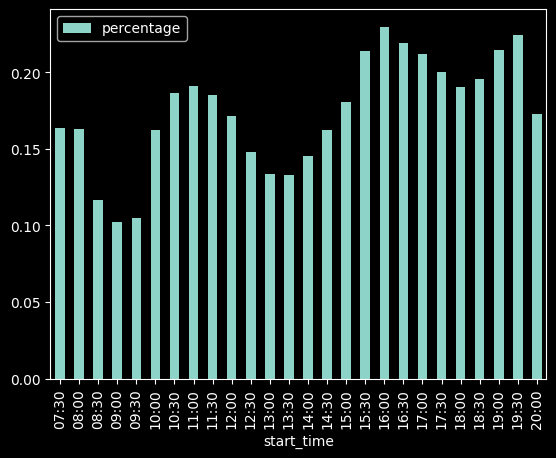

In [75]:
from matplotlib import pyplot as plt
import seaborn as sns
dfp[['start_time', 'percentage']].plot.bar(x='start_time', y='percentage')
plt.savefig(output_directory/'高新南环路.png')

In [ ]:
# plt.plot(高新南环路["start_time"], 高新南环路['percentatge'])